In [1]:
# imports
import pandas as pd
import numpy as np
import streamlit as st
import os
import datetime as dt
from dateutil.relativedelta import relativedelta
import requests
import pickle
import time

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pydeck as pdk

import lightgbm as lgb
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import shap

import resale_flat_prices_library as LIB

2021-10-19 17:45:41.283 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [3]:
# set tab name
st.set_page_config(page_title='Resale HDB Prices', page_icon='🏠')
# hide menu button
st.markdown(""" <style>
#MainMenu {visibility: hidden;}
footer {visibility: hidden;}
</style> """, unsafe_allow_html=True)
# title of app
st.title('Exploring Resale Prices of Public Housing in Singapore')
st.write('\n')
st.write('\n')

2021-10-19 17:45:46.065 
  command:

    streamlit run C:\Users\Russ\Anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


# Load data

In [47]:
### load data section ###

# cache data
@st.cache
# load data from csv
def load_data_from_csv(file_path):
    # read data
    data = pd.read_csv(file_path)
    # convert to year_month to datetime format
    data['year_month'] = pd.to_datetime(data['year_month'])
    # convert latitude and longitude to numeric
    data[['latitude', 'longitude']] = data[['latitude', 'longitude']].apply(pd.to_numeric)
    # return 
    return data

# define data directory
data_folder = 'data'
# cache data
@st.cache
# combine data
def combine_data(data_folder):
    # create empty dataframe to concat data later
    data_full = pd.DataFrame()
    # loop through each file in data_folder and concat into one df
    for file_name in os.listdir(data_folder):
        # load data
        temp_data = load_data_from_csv(os.path.join(data_folder, file_name))
        # concat data
        data_full = pd.concat([data_full, temp_data])
    # reset index to prevent duplicated indexes and drop created index column
    data_full = data_full.reset_index().drop('index', axis=1)
    return data_full
# combine data
data_full = combine_data(data_folder)

In [5]:
# get date range of full data set
min_data_date = data_full['year_month'].min().strftime('%B %Y')
max_data_date = data_full['year_month'].max().strftime('%B %Y')
total_row_count = '{:,}'.format(len(data_full))

# introduction to app
st.write('''
    Hi there! This app explores public housing or HDB resale prices in Singapore, it covers data visualisations,
     training and tuning a machine learning model to predict resale prices, and the explanation of the model\'s predictions. 
     The source code can be found on [Github](https://github.com/Greco1899/streamlit_resale_flat_prices) 
     and you can connect with me on [LinkedIn](https://www.linkedin.com/in/russellchanws).
    ''')
st.write('''
    The data has been extracted from [Data.gov.sg](https://data.gov.sg/dataset/resale-flat-prices) 
    and used in accordance with [Singapore Open Data License](https://data.gov.sg/open-data-licence).
    ''')
st.write(f'There are a total of {total_row_count} recorded resale flat transactions from {min_data_date} to {max_data_date}.')
st.write('\n')
st.write('\n')

# Pydeck Heat Map

In [6]:
### pydeck map using latitude and longitude section ###

# cache data
@st.cache
# filter data for map due to memory limit in streamlit
def filter_data_for_map(data, years):
    # get number of years to filter
    map_date = data['year_month'].max() - relativedelta(years=years)
    # filter data for map by years
    data_for_map = data.loc[(data['year_month'] >= map_date)]
    # return
    return data_for_map

# filter data for map due to memory limit in streamlit
# define max number of years
max_heatmap_years = 1
data_for_map = filter_data_for_map(data_full, max_heatmap_years)

# describe map
st.write(f'''
    Let\'s start by having a look at where flats have been transacted in the past {max_heatmap_years} year. 
    The taller the pillars, the more transactions have taken place.
    ''')
st.write('''
    The spikes are likely to be flats where the [Minimum Occupation Period](https://www.hdb.gov.sg/residential/selling-a-flat/eligibility) 
    has just passed and are eligible to be sold on the resale market.
    ''')

# create pydeck map in streamlit
def pydeck_map(data_for_map):
    # create map from pydeck
    layer=[
        pdk.Layer(
            'HexagonLayer',
            data=data_for_map,
            get_position='[longitude, latitude]',
            radius=40,
            elevation_scale=3,
            elevation_range=[0,500],
            pickable=True,
            extruded=True,
        ),
        pdk.Layer(
            'ScatterplotLayer',
            data=data_for_map,
            get_position='[longitude, latitude]',
            get_color='[200, 30, 0, 160]',
            get_radius=40,
        )
    ]

    st.pydeck_chart(pdk.Deck(
        map_style='mapbox://styles/mapbox/light-v9',
        initial_view_state=pdk.ViewState(latitude=1.355, longitude=103.81, zoom=10, pitch=40),
        layers=layer
        ))

# create pydeck map in streamlit
pydeck_map(data_for_map)
st.write('\n')
st.write('\n')

# Slider to Filter Data Period

In [7]:
### clean and filter data visualisation section ###

# slider to select period of years to visualise

# describe visualisation section
st.write(f'Next up is a deeper dive into the Resale Flat Prices data.')
# default minimum and maximum year from data
period_date_max = data_full['year_month'].max().year
period_date_min = data_full['year_month'].min().year
# define slider, default value max as latest data year and min as x years before
# define years before
default_years_before = 3
visualisation_period = st.slider('Select a period would you like to visualise.', min_value=period_date_min, max_value=period_date_max, value=(period_date_max-default_years_before,period_date_max))
# cache data
@st.cache
# filter data based on period
def filter_visualisation_data(data, visualisation_period):
    data = data.loc[(data['year_month'] >= str(visualisation_period[0])+'-01-01') & (data['year_month'] <= str(visualisation_period[1])+'-12-01')]
    return data
data = filter_visualisation_data(data_full, visualisation_period)

In [8]:
# get descriptive statistics of resale_price for selected period

# cache data
@st.cache
# describe resale_price column
def describe_data_column(data, column):
    data = data[column].describe()
    return data
period_describe = describe_data_column(data, 'resale_price')

# mean
period_mean = '{:,}'.format(round(period_describe['mean']))
# median
period_median = '{:,}'.format(round(period_describe['50%']))
# max
period_max = '{:,}'.format(round(period_describe['max']))
# get data for most expensive flat, if there is more than one, select latest transaction
most_expensive = data.loc[(data['resale_price'] == period_describe['max'])].reset_index(drop=True).sort_values('year_month', ascending=False).iloc[0]

# print descriptive statistics
st.write(f'In the period from {visualisation_period[0]} to {visualisation_period[1]}:')
st.write(f'The average resale flat price is ${period_mean} and the median is ${period_median}.')
st.write(f"""
    The most expensive flat sold for **${period_max}**! 
    The flat was transacted in {most_expensive['year_month'].strftime('%B %Y')} at 
    {most_expensive['block'].title()+' '+most_expensive['street_name'].title()}, 
    it was a {most_expensive['flat_type'].title()} with a {round(most_expensive['floor_area_sqm'])} square meter floor area.
    """)
st.write('\n')
st.write('\n')

# Visualise Data

In [9]:
### visualisation section ###

# set plot attributes
plot_figsize = (15,10)
plot_title_fontsize = 18
plot_axis_fontsize = 15

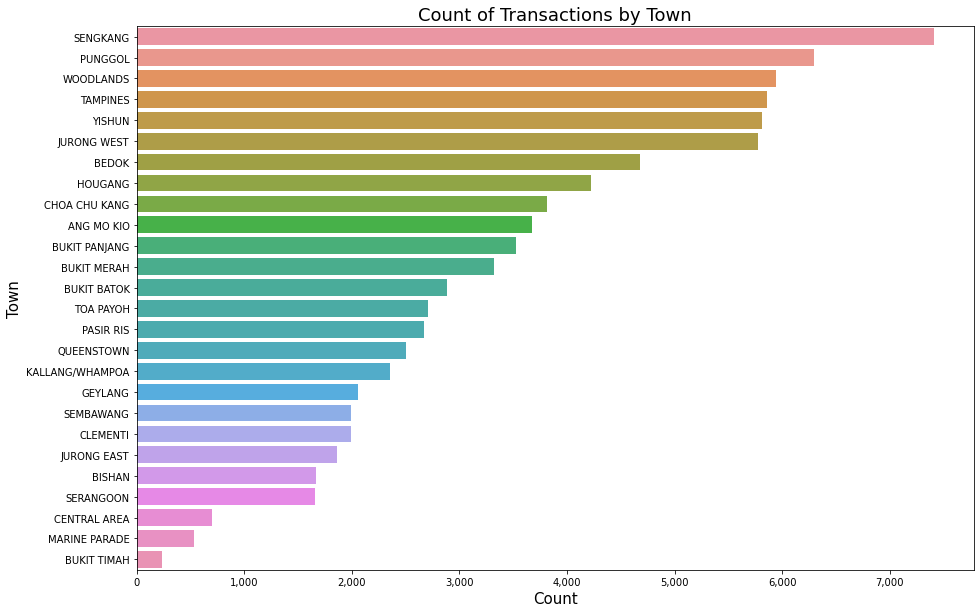

In [10]:
### histogram of town ###

# order by value count of town
town_order = data['town'].value_counts().index
# describe plot
st.write(f"This chart shows the number of transactions by Town. The most transactions occured in {town_order[0].title()}.")

# set plot and figure size
fig, ax = plt.subplots(figsize=plot_figsize)

# plot ax
ax = sns.countplot(
    y='town',
    data=data,
    order=town_order
)

# formatting
# add thousands separator
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# set title
ax.set_title('Count of Transactions by Town', fontsize=plot_title_fontsize)
ax.set_xlabel('Count', fontsize=plot_axis_fontsize)
ax.set_ylabel('Town', fontsize=plot_axis_fontsize)

# show plot
st.pyplot(fig)
st.write('\n')

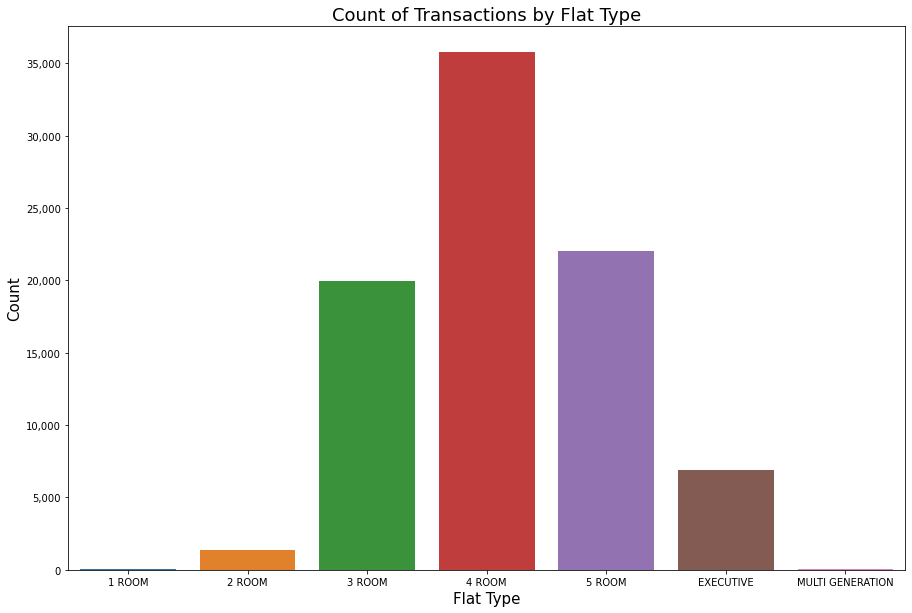

In [11]:
### histogram of flat type ###

# describe plot
st.write(f"""
    And this chart shows the number of transactions by Flat Type. 
    The most often transacted Flat Type are {data['flat_type'].value_counts().index[0].title()} flats.
    """)

# set plot and figure size
fig, ax = plt.subplots(figsize=plot_figsize)

# order by flat_type alphabetically
flat_type_order = sorted(list(data['flat_type'].unique()))

# plot ax
ax = sns.countplot(
    x='flat_type',
    data=data,
    order=flat_type_order
)

# formatting
# add thousands separator
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# set title
ax.set_title('Count of Transactions by Flat Type', fontsize=plot_title_fontsize)
ax.set_xlabel('Flat Type', fontsize=plot_axis_fontsize)
ax.set_ylabel('Count', fontsize=plot_axis_fontsize)

# show plot
st.pyplot(fig)
st.write('\n')

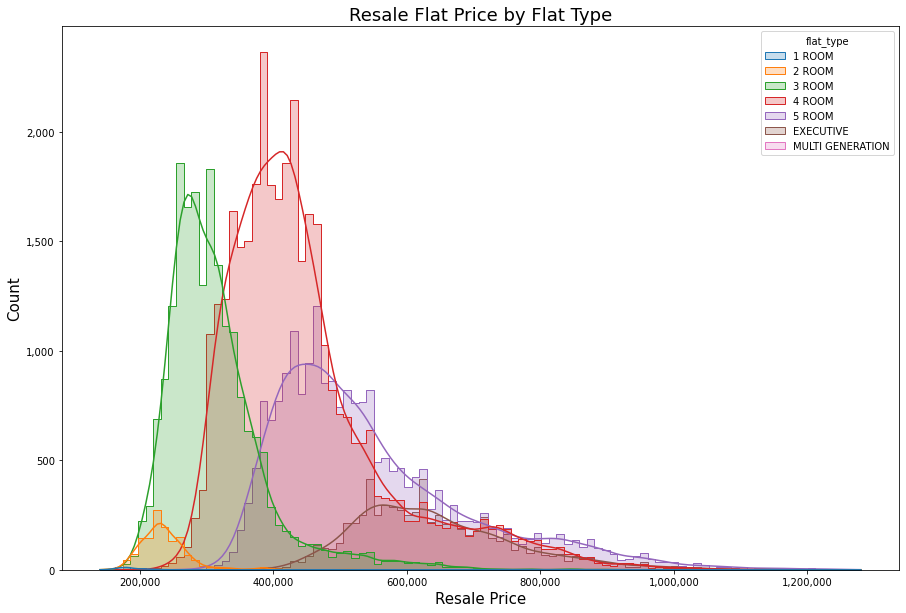

In [12]:
### histogram of flat prices ###

# describe plot
st.write(f"Here's a chart that shows the distribution of Resale Prices by Flat Type.")

# set plot and figure size
fig, ax = plt.subplots(figsize=plot_figsize)

# plot ax
ax = sns.histplot(
    x='resale_price',
    data=data.sort_values('flat_type'),
    bins=100,
    hue='flat_type',
    element='step',
    kde=True
)

# formatting
# add thousands separator
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# set title
ax.set_title('Resale Flat Price by Flat Type', fontsize=plot_title_fontsize)
ax.set_xlabel('Resale Price', fontsize=plot_axis_fontsize)
ax.set_ylabel('Count', fontsize=plot_axis_fontsize)

# show plot
st.pyplot(fig)
st.write('\n')

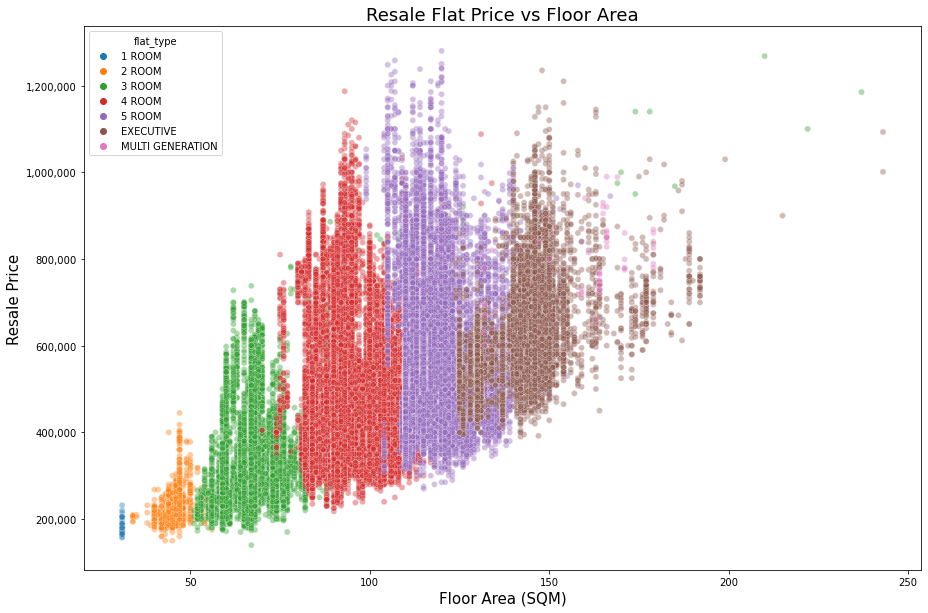

In [13]:
### scatterplot of resale_price and floor_area_sqm ###

# describe plot
st.write(f"""
    Now this is a scatterplot of Resale Prices compared to Floor Area. 
    No surprise here that we can see a general trend that a flat with more rooms and space cost more.
    """)
st.write(f"However, we can also see that similar flats with the same floor area and flat type can vary significantly in price!")

# set plot and figure size
fig, ax = plt.subplots(figsize=plot_figsize)

# plot ax
sns.scatterplot(
    x='floor_area_sqm',
    y='resale_price',
    data=data.sort_values('flat_type'),
    hue='flat_type',
    alpha=0.4
)

# formatting
# add thousands separator
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# set title
ax.set_title('Resale Flat Price vs Floor Area', fontsize=plot_title_fontsize)
ax.set_xlabel('Floor Area (SQM)', fontsize=plot_axis_fontsize)
ax.set_ylabel('Resale Price', fontsize=plot_axis_fontsize)

# show plot
st.pyplot(fig)
st.write('\n')

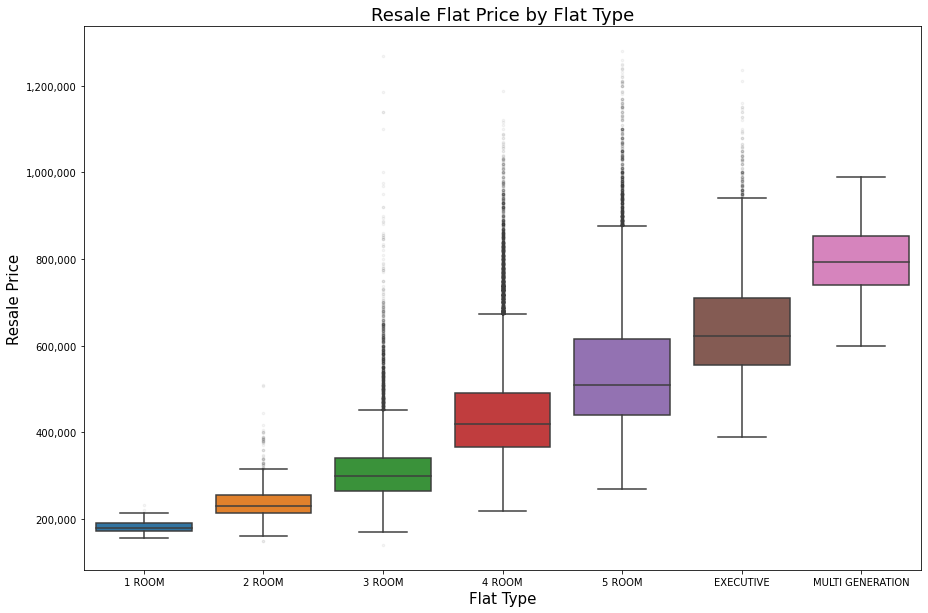

In [14]:
### boxplot of flat type ###

# describe plot
st.write("""
    These are boxplots of Resale Prices by different Flat Types. 
    Here's a quick refresher on how to [read boxplots](https://miro.medium.com/max/2400/1*2c21SkzJMf3frPXPAR_gZA.png) if you need it.
    """)

# set plot and figure size
fig, ax = plt.subplots(figsize=plot_figsize)

# order by flat_type alphabetically
flat_type_order = sorted(list(data['flat_type'].unique()))

# plot ax
ax = sns.boxplot(
    x='flat_type', 
    y='resale_price', 
    data=data,
    order=flat_type_order, 
    flierprops={'marker':'.', 'alpha':0.05}
    )

# formatting
# add thousands separator
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# set title
ax.set_title('Resale Flat Price by Flat Type', fontsize=plot_title_fontsize)
ax.set_xlabel('Flat Type', fontsize=plot_axis_fontsize)
ax.set_ylabel('Resale Price', fontsize=plot_axis_fontsize)

# show plot
st.pyplot(fig)
st.write('\n')

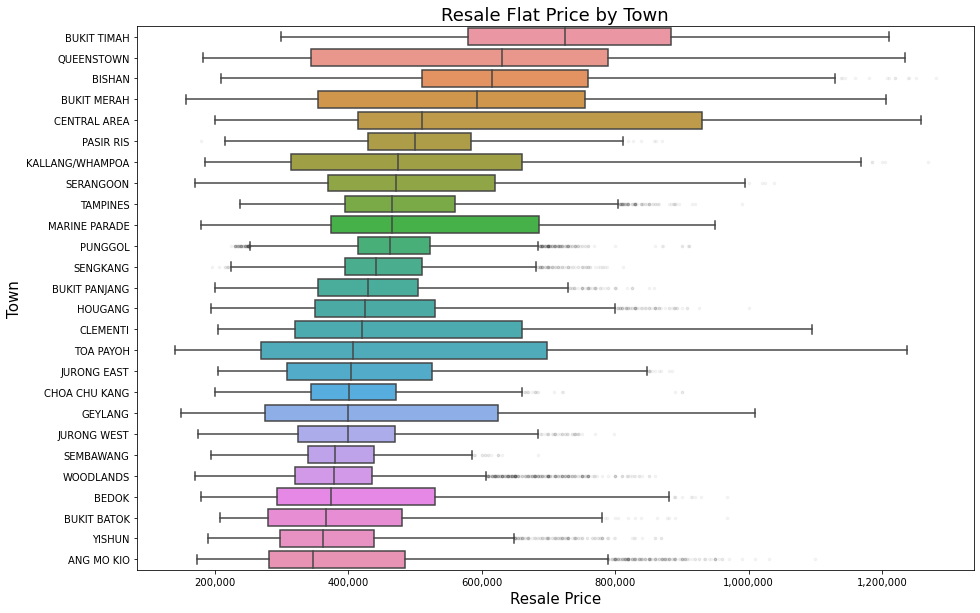

In [15]:
### boxplot of town ###

# group by town and get median resale price
town_median_resale_price = data.groupby(['town']).agg({'resale_price':'median'}).reset_index().sort_values('resale_price', ascending=False)
# get town with highest median 
most_expensive_town = town_median_resale_price['town'].iloc[0].title()
# get town with lowest median
least_expensive_town = town_median_resale_price['town'].iloc[-1].title()
# compare and get difference between highest median and lowest median
median_price_difference = round(town_median_resale_price['resale_price'].iloc[0] / town_median_resale_price['resale_price'].iloc[-1], 1)
# order by descending median resale_price
town_order = list(town_median_resale_price['town'])

# describe plot
st.write(f"Here are more pretty boxplots of Resale Prices by Town. The most expensive area to buy a flat is in {most_expensive_town}.")
st.write(f"""
    Apart from the floor area and flat type, the location of the flat can also influence the price. 
    The median price of a flat in {most_expensive_town} is **{median_price_difference}** times higher than {least_expensive_town}!
    """)

# set plot and figure size
fig, ax = plt.subplots(figsize=plot_figsize)

# plot boxplot
sns.boxplot(
    x='resale_price', 
    y='town', 
    data=data, 
    order=town_order,
    flierprops={'marker':'.', 'alpha':0.05}
    )

# formatting
# add thousands separator
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# set title and axis
ax.set_title('Resale Flat Price by Town', fontsize=plot_title_fontsize)
ax.set_xlabel('Resale Price', fontsize=plot_axis_fontsize)
ax.set_ylabel('Town', fontsize=plot_axis_fontsize)

# show plot
st.pyplot(fig)
st.write('\n')

# Prediction

In [16]:
### prediction section ###

st.write('\n')
st.write('# Predicting Resale Flat Price')
st.write('''
    Enter some basic information (or just try it out with the default values) of the flat you want to 
    sell or buy for the model to predict it\'s price.
    ''')

# form to store users input
with st.form(key='input_form'):

    # ask and store users input
    input_postal_code = st.text_input(label='Postal Code', value='440033')
    input_floor_area_sqm = st.number_input(label='Floor Area in square meters (1 square meter approximately 10 square feet) ', min_value=1, max_value=500, value=70, step=10)
    input_floor = st.number_input(label='Floor', min_value=1, max_value=100, value=10, step=2)
    input_lease_commence_year = st.number_input(label='Lease Commence Year', min_value=1900, max_value=dt.date.today().year, value=1975, step=1)

    # get latitude and longitude from postal code
    coordinates = LIB.get_coordinates_from_address(input_postal_code+' Singapore', st.secrets['geocode_api_key'])
    # calculate remaining lease years from lease commencement date
    input_remaining_lease_years = dt.date.today().year - input_lease_commence_year

    # format user inputs into df for xgb prediction
    input_data = pd.DataFrame({
        'latitude':[coordinates[0]],
        'longitude':[coordinates[1]],
        'floor_area_sqm':[input_floor_area_sqm],
        'floor':[input_floor],
        'remaining_lease_years':[input_remaining_lease_years]
    })

    # submit form button
    st.write('First, load the inputs to the machine learning model to prepare for a prediction:')
    submit = st.form_submit_button(label='Load')

In [17]:
# load model
model = pickle.load(open('lgb_baseline.pkl', 'rb'))

# describe predict button
st.write('Second, take a guess at the price before running the model 😊.')

# add predict button
if st.button('Predict'):
    # predict input_data using model
    prediction = model.predict(input_data)[0]
    # format prediction with thousands separator and round to two decimal places
    prediction = '{:,}'.format(round(prediction))
    # print prediction
    st.success(f'''
        The predicted resale price of a flat at postal code {input_postal_code}, 
        with a floor area of {input_floor_area_sqm} square meters, on the {input_floor} floor, 
        and with a lease that commenced in {input_lease_commence_year} is **${prediction}**!
        ''')

st.write('After submitting the prediction, we will move on to the next section and take a more technical look at how we develop a model!')
st.write('\n')
st.write('\n')

# Preparing Data for Modelling

In [18]:
### modelling section ###

# cache data
@st.cache
# describe data
def describe_data(data):
    data = data.describe()
    return data
data_full_description = describe_data(data_full)

# describe full data set and show dataframe
st.write('# Preparing Data')
st.write('Here are some summary statistics of the full data set.')
st.dataframe(data_full_description)
st.write('\n')
st.write('\n')

In [19]:
st.write('Singapore and its public housing landscape has changed significantly over the years and will continue to change.')
st.write(f'''
    As the data spans over {round((period_date_max - period_date_min) / 10)} decades, 
    we should make use of recent data to train our model. The question is how recent?
    ''')
st.write('''
    Lets perform an experiment to determine how many years of data should we train a machine learning model on 
    to be the most accurate in predicting future resale flat prices.
    ''')
st.write('\n')
# define number of months of test data to use
experiment_test_months = st.slider('Select number of months of test data to use for experiment.', min_value=1, max_value=6, value=3)
# set minimum number of years of training data
min_train_years = 2
# define number of years of train data to use
experiment_train_years = st.slider('Select number of years of training data.', min_value=min_train_years+1, max_value=10, value=5)

st.write(f'We will use {experiment_test_months} months of test data and experiment with up to {experiment_train_years} years of training data.')
st.write('\n')

# Selecting Model

In [20]:
### selecting model section ###

st.write('''
    The model chosen is a Light Gradient Boosting Machine or [LightGBM](https://github.com/microsoft/LightGBM#readme) 
    for its efficiency and speed to improve performance on this web app. 
    Mean Absolute Error (MAE) will be the metric that is used for evaluation.
    ''')
st.write('''
    Is LightGBM faster than XGBoost? Hit the \'Train and Compare\' button to train a XGBoost and a LightGBM model 
    and we can compare the training time taken and MAE using the above selected test and train data!
    ''')

# define random state
random_state = 42
# define model 
lgb_baseline = lgb.LGBMRegressor(
    random_state=random_state, 
    metric='mae'
    )
# define model 
xgb_baseline = xgb.XGBRegressor(
    random_state=random_state
)

# add train and compare button
if st.button('Train and Compare'):
    with st.spinner('Training models...'):
        # filter and split data into train and test set
        temp_train_data, temp_test_data = LIB.filter_and_split_data(clean_data=data_full, test_months=experiment_test_months, train_years=experiment_train_years)

        # set timer to start
        lgb_time_start = time.perf_counter()
        # train, validate, and test model
        lgb_model, lgb_results = LIB.train_validate_test_model(train_data=temp_train_data, test_data=temp_test_data, train_years=experiment_train_years, model=lgb_baseline, random_state=random_state)
        # set timer to end
        lgb_time_end = time.perf_counter()
        # get time taken
        lgb_time_taken = round(lgb_time_end - lgb_time_start, 2)

        # set timer to start
        xgb_time_start = time.perf_counter()
        # train, validate, and test model
        xgb_model, xgb_results = LIB.train_validate_test_model(train_data=temp_train_data, test_data=temp_test_data, train_years=experiment_train_years, model=xgb_baseline, random_state=random_state)
        # set timer to end
        xgb_time_end = time.perf_counter()
        # get time taken
        xgb_time_taken = round(xgb_time_end - xgb_time_start, 2)

        # compare mae and get difference
        mae_difference = lgb_results - xgb_results
        # get mae from df
        mae_difference = mae_difference["test_mae"][0]
        # convert difference to percentage
        mae_difference_percentage = round((mae_difference / xgb_results["test_mae"][0]) * 100, 2)
        # compare time and get difference
        time_difference = lgb_time_taken - xgb_time_taken
        # convert difference to percentage
        time_difference_percentage  = round((time_difference / xgb_time_taken) * 100, 2)

        # check results and print message
        if time_difference < 0 and mae_difference >= 0:
            st.success('The results are in: LightGBM is a lot faster but slightly less accurate!')
        elif time_difference < 0 and mae_difference < 0:
            st.success('The results are in: LightGBM is a lot faster and slightly more accurate!')
        elif time_difference >= 0 and mae_difference >= 0:
            st.success('The results are in: LightGBM is slower and slightly less accurate!')
        elif time_difference >= 0 and mae_difference < 0:
            st.success('The results are in: LightGBM is slower but slightly more accurate!')

        # create columns
        col1, col2, col3, col4 = st.columns(4)
        # show xgb mae
        col1.metric('XGBoost MAE:', f'{"{:,}".format(round(xgb_results["test_mae"][0]))}')
        # show lgb mae
        col2.metric('LightGBM MAE:', f'{"{:,}".format(round(lgb_results["test_mae"][0]))}', f'{mae_difference_percentage}%', 'inverse')
        # show xgb time taken
        col3.metric('XGBoost Time:', f'{xgb_time_taken} Seconds')
        # show lgb time taken
        col4.metric('LightGBM Time:', f'{lgb_time_taken} Seconds', f'{time_difference_percentage}%', 'inverse')
        st.write('\n')
        
st.write('\n')

In [48]:
# cache data
@st.cache
# define experiment function
def run_experiment(data_full):
    # create empty df
    experiment_recency = pd.DataFrame()
    # create loop to define number of years of training data to use
    for i in range(1, experiment_train_years+1):
        # filter and split data into train and test set
        temp_train_data, temp_test_data = LIB.filter_and_split_data(clean_data=data_full, test_months=experiment_test_months, train_years=i)
        # train, validate, and test model
        temp_model, temp_results = LIB.train_validate_test_model(train_data=temp_train_data, test_data=temp_test_data, train_years=i, model=lgb_baseline, random_state=random_state)
        # concat results for each year
        experiment_recency = pd.concat([experiment_recency, temp_results])
    return experiment_recency
# run experiment
experiment_recency = run_experiment(data_full)

# get mae of 1 year training data
experiment_best_mae = round(experiment_recency['test_mae'].iloc[0])

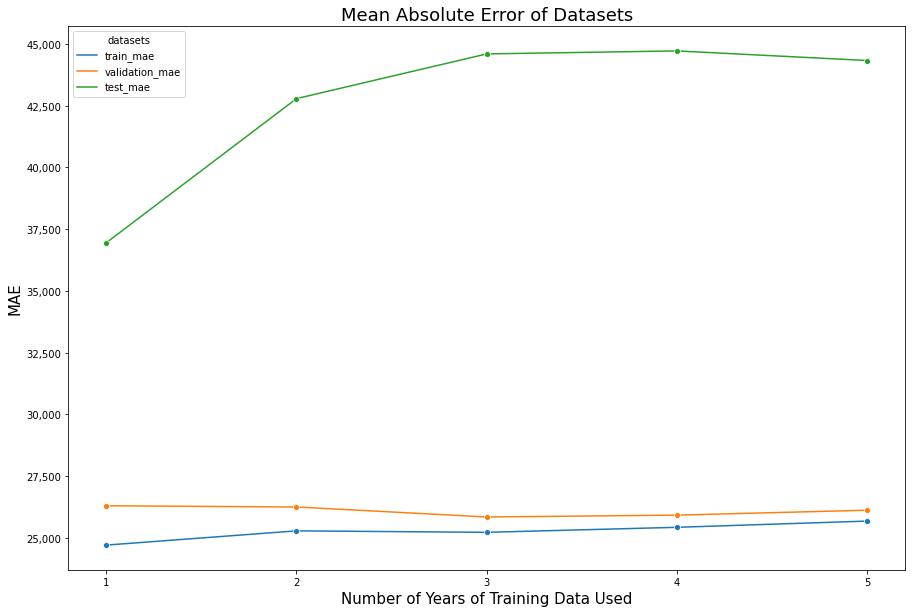

In [22]:
### lineplot of train, validation, test mae over number of train years ###

# describe plot
st.write('Below we have a chart that shows the performance of the LightGBM model using Mean Absolute Error.')
st.write('''
    Focusing on the MAE of the test dataset (the lower the better), 
    we can see that the model performs well using 1 year of training data.
    ''')
st.write('''
    We can intepret the MAE as the mean error when the model is trying to predict the resale price of flats across 
    all records in the test dataset. For example, if a flat\'s actual resale price is $400,000 and the model predicted it to be 
    $380,000, the absolute error is 20,000. And the mean absolute error simply getting the mean of all the errors of the model.
    ''')
st.write(f'Using 1 year of training data results in an MAE of {"{:,}".format(experiment_best_mae)}')

# drop train_validation_mae_difference
experiment_recency_long = experiment_recency.drop('train_validation_mae_difference', axis=1)
# convert data from 'wide' to 'long'
experiment_recency_long = pd.melt(experiment_recency_long, ['train_years'])
# rename columns
experiment_recency_long = experiment_recency_long.rename(columns={'variable':'datasets', 'value':'mae'})

# set plot and figure size
fig, ax = plt.subplots(figsize=plot_figsize)

# plot ax
ax = sns.lineplot(
    x='train_years', 
    y='mae', 
    data=experiment_recency_long, 
    hue='datasets',
    marker='o'
)

# formatting
# add thousands separator
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticks(np.arange(1, experiment_train_years+1, 1))
# set title
ax.set_title('Mean Absolute Error of Datasets', fontsize=plot_title_fontsize)
ax.set_xlabel('Number of Years of Training Data Used', fontsize=plot_axis_fontsize)
ax.set_ylabel('MAE', fontsize=plot_axis_fontsize)

# show plot
st.pyplot(fig)
st.write('\n')
st.write('\n')

# Tune Model Hyperparameters

In [23]:
### tune model hyperparameters section ###

st.write('# Tuning Model Hyperparameters')
st.write('The LightGBM model accuracy can be further improved through hyperparameter tuning!')
st.write('''
    Instead of using Grid Search or Random Search to tune the hyperparameters, we will be making use of the 
    [Optuna framework](https://optuna.org/) which employs an efficient algorithm to automatically search for the ideal hyperparameters.
    ''')

# define optuna objective for lgb model
def optuna_objective_lightgbm(trial, train_data, test_data, fixed_params):
    '''
    define train, valid, and test data and convert to Dataset for lgb
    define optuna objective to tune hyperparameters of lightgbm models
    define hyperparameters to trial, details on what to tune can be found here https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
    train lgb model on train data and validate on valid data
    add pruning to prune trials that under perform i.e. mae of trial is worse than previous trials, speeding up the optimisation process
    test model on test data to get mean absolute error as target of optimisation

    arguments:
    train_data (df): training data set
    test_data (df): test data set

    returns:
    mean absolute error of lgb model on test data
    '''
    # set X and y using train data
    X = train_data.drop('resale_price', axis=1)
    y = train_data['resale_price']
    # set train and valid data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_state)
    # set X_test, y_test using test data
    X_test = test_data.drop('resale_price', axis=1)
    y_test = test_data['resale_price']
    # convert data to Dataset object for lgb
    d_train = lgb.Dataset(X_train, label=y_train)
    d_test = lgb.Dataset(X_valid, label=y_valid)

    # set params
    param = {
        **fixed_params,
        **{'num_leaves': trial.suggest_int('num_leaves', 2, 200), # small num_leaves to avoid overfitting
            'max_depth': trial.suggest_int('max_depth', 1, 20), # small max_depth to avoid overfitting
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-5, 1.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 1.0, log=True),
            'min_gain_to_split': trial.suggest_float('min_gain_to_split', 1e-5, 1.0, log=True),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 100)
            }
        }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'l1')
    # train model
    model = lgb.train(param, d_train, valid_sets=[d_test], early_stopping_rounds=10, verbose_eval=False, callbacks=[pruning_callback])
    # predict using model
    y_pred = model.predict(X_test)
    # get mean absolute error of test data
    mae = mean_absolute_error(y_test, y_pred)

    # return
    return mae

In [24]:
# cache data
@st.cache
# filter and split data into train and test set
def get_train_test_data(data_full):
    train_data, test_data = LIB.filter_and_split_data(clean_data=data_full, test_months=3, train_years=1)
    return train_data, test_data
train_data, test_data = get_train_test_data(data_full)

# defined fixed hyperparameters for lgbmregressor
fixed_params = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'random_state': 42,
    'boosting_type': 'gbdt'
    }

In [25]:
# define study with pruning
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize")
# define lambda function to add arguments
objective = lambda trial: optuna_objective_lightgbm(trial, train_data, test_data, fixed_params)
# slider to select number of trials to perform
# n_trials = st.slider('Select number of trials to perform.', min_value=10, max_value=30, value=10)
n_trials = 10

# set timer to start
time_start = time.perf_counter()
# optimise study with defined number of trials to perform, add spinner as optimisation takes a while to run
with st.spinner('Optimising hyperparameters...'):
    # optimise study
    study.optimize(objective, n_trials=n_trials)
# set timer to end
time_end = time.perf_counter()
# time taken
time_taken = round(time_end - time_start)

# get best metric
best_value = round(study.best_value)
# get best params of metric
best_params = study.best_params
# calculate improvement over untuned model
improvement = abs(best_value - experiment_best_mae)
# print improved mae and best params
st.success(
    f'''
    Hyperparameters tuning is complete! 
    The tuned LightGBM model achieved a MAE of {"{:,}".format(best_value)} with {n_trials} trials which took {time_taken} seconds, 
    this is an improvement of {"{:,}".format(improvement)} over the untuned model which had a MAE of {"{:,}".format(experiment_best_mae)}.
    '''
    f'{os.linesep}'
    f'And here are the tuned hyperparameters\' values:'
    )
st.json(best_params)
st.write('\n')
st.write('\n')

[I 2021-10-19 17:46:18,093] A new study created in memory with name: no-name-5bccdb1c-96c9-49ef-9a91-912bfd66d20f
Found `n_estimators` in params. Will use it instead of argument
[I 2021-10-19 17:46:22,742] Trial 0 finished with value: 35288.933209224015 and parameters: {'num_leaves': 169, 'max_depth': 19, 'learning_rate': 0.0559676602046509, 'n_estimators': 1111, 'lambda_l1': 2.4066853997622374e-05, 'lambda_l2': 0.00015039348200687096, 'min_gain_to_split': 0.0025846618447240804, 'feature_fraction': 0.45099897860384913, 'bagging_fraction': 0.6912160619501746, 'bagging_freq': 8, 'min_child_samples': 40}. Best is trial 0 with value: 35288.933209224015.
Found `n_estimators` in params. Will use it instead of argument
[I 2021-10-19 17:46:24,563] Trial 1 finished with value: 35936.868596270986 and parameters: {'num_leaves': 116, 'max_depth': 4, 'learning_rate': 0.06201735401482658, 'n_estimators': 1316, 'lambda_l1': 0.00016551010735500908, 'lambda_l2': 0.0008057269931397098, 'min_gain_to_spli

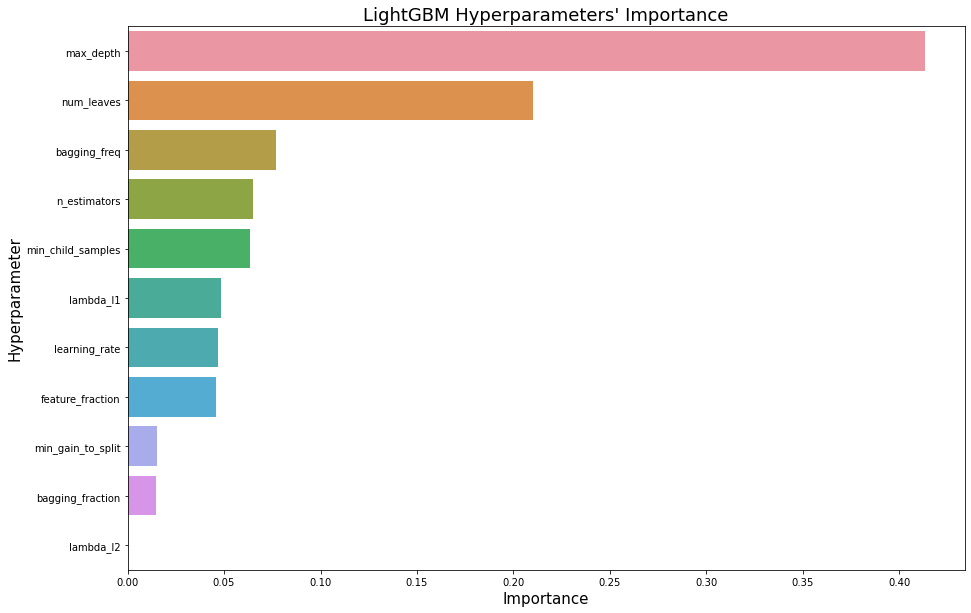

In [26]:
### barplot of hyperparameters importance ###

# get param importances
hyperparam_importance = optuna.importance.FanovaImportanceEvaluator(seed=random_state).evaluate(study)
# convert ordereddict into data frame, transpose and rename columns
hyperparam_importance = pd.DataFrame(hyperparam_importance, index=[0]).T.reset_index().rename(columns={'index':'hyperparameters', 0:'importance'})

# describe plot
st.write('There are so many hyperparameters that can be tuned, how can we determine which ones are the most important to focus on if we want to fine tune the model further?')
st.write(f'This next chart can help! We can view the importance of each hyperparameter with the most important being "_{hyperparam_importance["hyperparameters"][0]}_".')
st.write(f'Something to note, the importance will be more robust with as more trails performed, but it has been limited to a small number of {n_trials} trials for as an example.')
st.write('\n')

# set plot and figure size
fig, ax = plt.subplots(figsize=plot_figsize)

# plot ax
ax = sns.barplot(
    x='importance', 
    y='hyperparameters', 
    data=hyperparam_importance
)

# formatting
# set title
ax.set_title('LightGBM Hyperparameters\' Importance', fontsize=plot_title_fontsize)
ax.set_xlabel('Importance', fontsize=plot_axis_fontsize)
ax.set_ylabel('Hyperparameter', fontsize=plot_axis_fontsize)

# show plot
st.pyplot(fig)
st.write('\n')
st.write('\n')

# Train Model

In [27]:
### train and predict section ###

st.write('# Train Model and Predict')
st.write('Now we will train our model using the optimised hyperparameters, make a prediction using the earlier input.')

# set X and y using train data
X_train = train_data.drop('resale_price', axis=1)
y_train = train_data['resale_price']
# set X_test, y_test using test data
X_test = test_data.drop('resale_price', axis=1)
y_test = test_data['resale_price']
# convert data to Dataset object for lgb
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [52]:
# fit and train
lgb_model = lgb.train({**fixed_params, **study.best_params}, d_train, valid_sets=[d_test], early_stopping_rounds=10, verbose_eval=False)
# use trained model to predict unseen test data
model_predictions, model_mae, model_rmse = LIB.pred_model(lgb_model, X_test, y_test, to_print=False)

# predict input_data using model
tuned_prediction = lgb_model.predict(input_data)[0]
# format prediction with thousands separator and round to two decimal places
tuned_prediction = '{:,}'.format(round(tuned_prediction))

st.success(f'Using the optimised LightGBM model, it predicted resale price of a flat at postal code {input_postal_code}, with a floor area of {input_floor_area_sqm} square meters, on the {input_floor} floor, and with a lease that commenced in {input_lease_commence_year} to be **${tuned_prediction}**!')
st.write('\n')
st.write('\n')

Found `n_estimators` in params. Will use it instead of argument


# Explain Model

In [54]:
### explain model section ###

# define number of samples to use
number_of_samples = 2500
# filter X_train by number of samples
X_train_filtered = X_train[-number_of_samples:]

st.write('# Explaining the Model')
st.write(f'''
    Now we will explore how does each feature impacts the predicted resale price using 
    [SHAP (SHapley Additive exPlainations)](https://github.com/slundberg/shap#readme) with {number_of_samples} samples from the data.
    ''')
st.write('\n')

# cache data
@st.cache
def shap_explainer(model, X_train):
    # explain the model's predictions using SHAP
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)
    return shap_values

# with st.spinner('Generating Feature Explaination...'):
shap_values = shap_explainer(lgb_model, X_train_filtered)

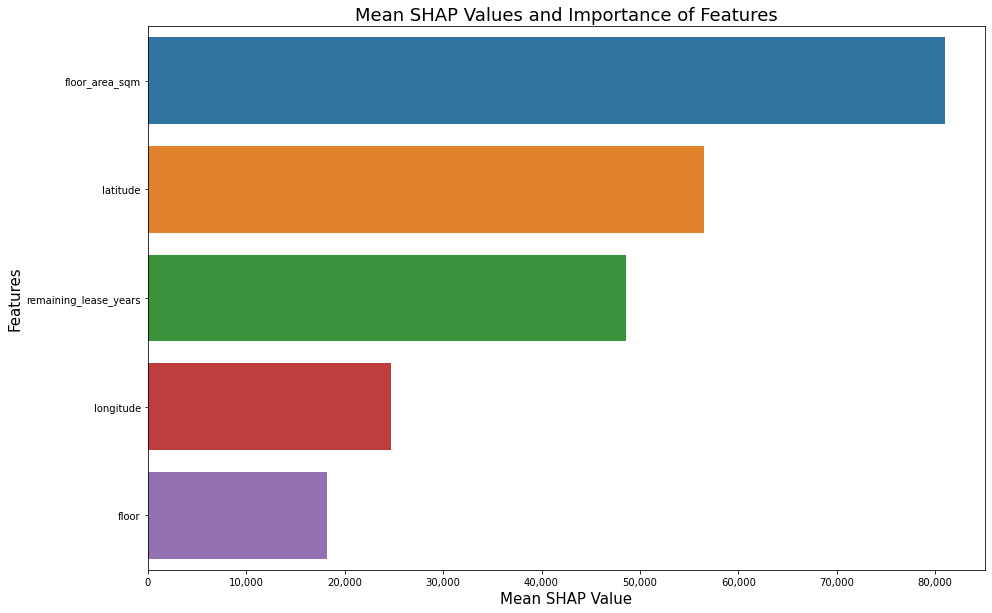

In [55]:
### barplot of mean shap values ###

# create df to store features and shap values
mean_shap_values = pd.DataFrame({
    'features':X_train_filtered.columns.tolist(), 
    'shap_values':abs(shap_values.values).mean(axis=0).tolist()
    })
# sort by importance
mean_shap_values = mean_shap_values.sort_values('shap_values', ascending=False)
# describe plot
st.write(f'Here we have the mean SHAP values of each of the features, and most important feature is "_{mean_shap_values["features"].iloc[0]}_".')

# set plot and figure size
fig, ax = plt.subplots(figsize=plot_figsize)

# plot ax
sns.barplot(
    x='shap_values', 
    y='features', 
    data=mean_shap_values
    )

# formatting
# add thousands separator
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# set title
ax.set_title('Mean SHAP Values and Importance of Features', fontsize=plot_title_fontsize)
ax.set_xlabel('Mean SHAP Value', fontsize=plot_axis_fontsize)
ax.set_ylabel('Features', fontsize=plot_axis_fontsize)

# show plot
st.pyplot(fig)
st.write('\n')

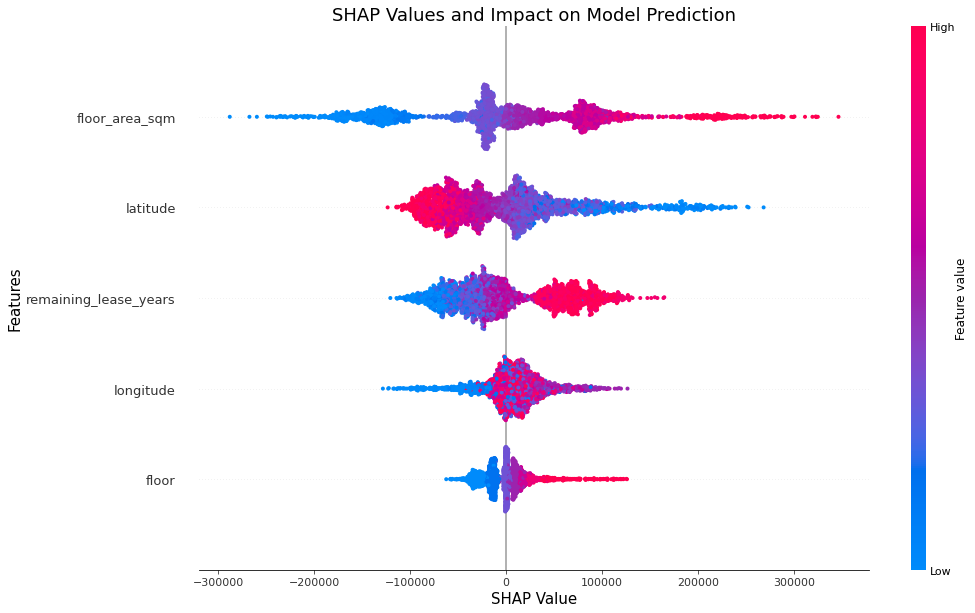

In [56]:
### swarmplot of shap values of each data point ###

# describe plot
st.write(f'The below plot summarises all {"{:,}".format(number_of_samples)} data points in the training data set and shows the positive or negative impact on the outcome of the model.')
st.write('We can see that for a high "_floor_area_sqm_" (coloured pink) has a high positive impact on resale price, while a low "_floor_area_sqm_" (coloured blue) has a high negative impact on the resale price.')
st.write('''
    Taking "_latitude_" as another example, we can observe that a flat with a low "_latitude_" (located further south) 
    has a bigger positive impact on it\'s resale price than a flat with a higher "_latitude_" (located further north).
    ''')

# set plot and figure size
fig, ax = plt.subplots(figsize=plot_figsize)

# plot
shap.plots.beeswarm(shap_values, show=False)
# get current figure
fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(10)

# formatting
# set title
ax.set_title('SHAP Values and Impact on Model Prediction', fontsize=plot_title_fontsize)
ax.set_xlabel('SHAP Value', fontsize=plot_axis_fontsize)
ax.set_ylabel('Features', fontsize=plot_axis_fontsize)

# show plot
st.pyplot(fig)
st.write('\n')

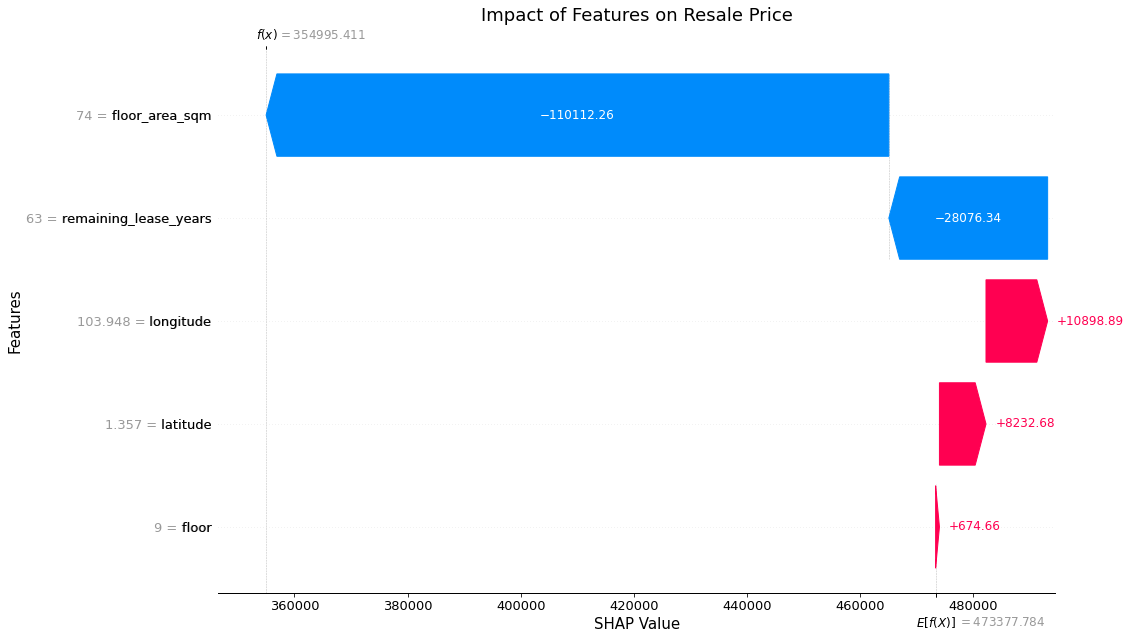

In [83]:
### waterfall plot of shap values of one data point ###

# define sample row to inspect in detail
sample_row = 42
# get average predicted shap value or base shap value
averge_predict_value = round(shap_values.base_values[sample_row], 3)
# get predicted shap value
sample_predict_value = round(averge_predict_value + shap_values.values[sample_row].sum(), 3)
# create dataframe of sample with features and respective shap values
waterfall_sample = pd.DataFrame({
    'features':list(X_train_filtered),
    'feature_values':X_train_filtered.iloc[sample_row],
    'shap_values':shap_values.values[sample_row].tolist(),
    'shap_impact':abs(shap_values.values[sample_row]).tolist()
})
# sort waterfall_sample by shap_values in descending order
waterfall_sample = waterfall_sample.sort_values('shap_impact', ascending=False)

# describe plot
st.write('''
    Apart from having an explainatory overview of how each feature impacts the model, 
    we can also focus in on 1 sample using a waterfall plot below to show how each of the 
    features impact or move the resale price of the sample.
    ''')
st.write('There\'s quite a lot going on here but we\'ll break it down one step at a time.')
st.write(f'''
    On the Y axis, we can see the features and respective values of the sample with the most impactful feature, 
    "_{waterfall_sample["features"].iloc[0]}_" at the top and the least impactful feature, 
    "_{waterfall_sample["features"].iloc[-1]}_" at the bottom.
    ''')
st.write(f'''
    Next up on the X axis, we see the value {averge_predict_value}, that is the average predicted resale price of our training data. 
    And on the top of the chart we can see the value {sample_predict_value} which is the model\'s predicted resale price of this sample.
    ''')
st.write(f'''
    And finally in the main chart area, we can inspect how each of the features \'forces\' 
    the resale price from {averge_predict_value} towards {sample_predict_value}. 
    A "_{waterfall_sample["features"].loc[waterfall_sample["shap_values"].idxmax()]}_" of 
    {round(waterfall_sample["feature_values"].loc[waterfall_sample["shap_values"].idxmax()], 3)} 
    increases the resale price the most while a 
    "_{waterfall_sample["features"].loc[waterfall_sample["shap_values"].idxmin()]}_" of 
    {round(waterfall_sample["feature_values"].loc[waterfall_sample["shap_values"].idxmin()])} 
    reduces the resale price the most.
    ''')

# set plot and figure size
fig, ax = plt.subplots(figsize=plot_figsize)

# plot
shap.plots.waterfall(shap_values[sample_row], show=False)
# get current figure
fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(10)

# formatting
# set title
ax.set_title('Impact of Features on Resale Price', fontsize=plot_title_fontsize)
ax.set_xlabel('SHAP Value', fontsize=plot_axis_fontsize)
ax.set_ylabel('Features', fontsize=plot_axis_fontsize)

# show plot
st.pyplot(fig)
st.write('\n')

In [92]:
waterfall_sample["feature_values"].loc[waterfall_sample["shap_values"].idxmin()]

74.0

In [90]:
waterfall_sample["features"].loc[waterfall_sample["shap_values"].idxmin()]

'floor_area_sqm'

In [91]:
waterfall_sample["features"].loc[waterfall_sample["shap_values"].idxmax()]

'longitude'

In [93]:
waterfall_sample["feature_values"].loc[waterfall_sample["shap_values"].idxmax()]

103.9481853

In [87]:
waterfall_sample.loc[(waterfall_sample['shap_values'] == waterfall_sample['shap_values'].max())]

,features,feature_values,shap_values,shap_impact
longitude,longitude,103.948185,10898.893023,10898.893023


In [84]:
waterfall_sample['shap_values'].max()

10898.893023136334

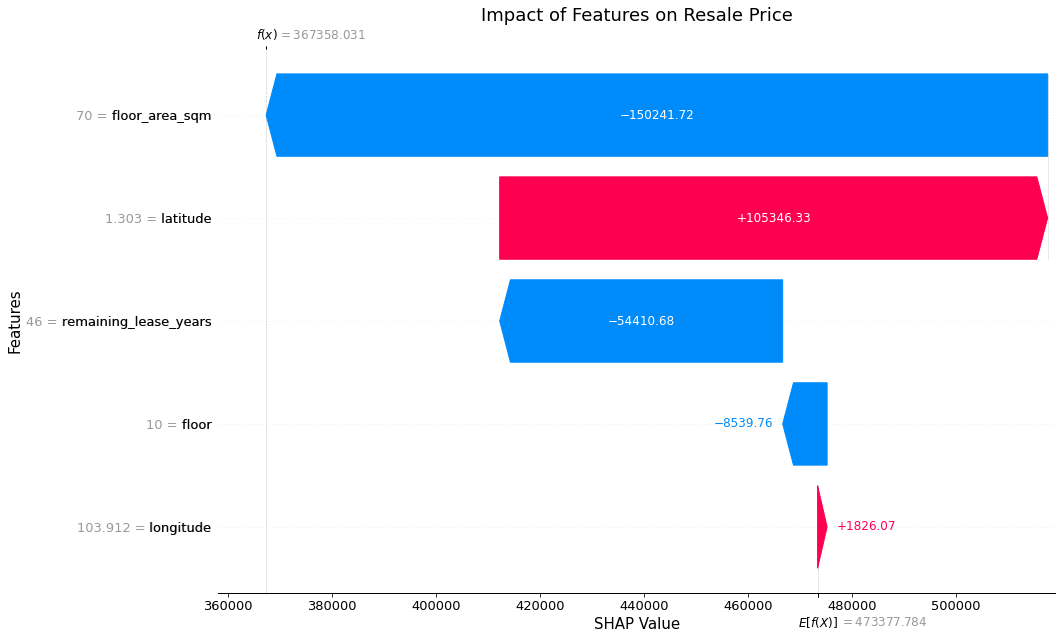

In [70]:
### waterfall plot of shap values of one data point ###

# describe plot
st.write('Here a look at another example using your earlier inputs!')

# find shap values of earlier input data used for prediction
explainer = shap.Explainer(lgb_model)
shap_values_input = explainer(input_data)

# set plot and figure size
fig, ax = plt.subplots(figsize=plot_figsize)

# plot
shap.plots.waterfall(shap_values_input[0], show=False)
# get current figure
fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(10)

# formatting
# set title
ax.set_title('Impact of Features on Resale Price', fontsize=plot_title_fontsize)
ax.set_xlabel('SHAP Value', fontsize=plot_axis_fontsize)
ax.set_ylabel('Features', fontsize=plot_axis_fontsize)

# show plot
st.pyplot(fig)
st.write('\n')
st.write('\n')
st.write('\n')

# End Notes

In [38]:
### end notes ###

st.write('_That\'s all folks!_ Thanks for viewing 😎.')
st.write('''
    I\'m always looking for feedback so do reach out and connect with me on [LinkedIn](https://www.linkedin.com/in/russellchanws) 
    and the source code can be found on [Github](https://github.com/Greco1899/streamlit_resale_flat_prices).
    ''')
st.write('\n')
st.write('\n')
st.write('\n')
st.image('https://images.unsplash.com/photo-1617275249641-322ed29f098e?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2671&q=80')
st.caption('Photo by [Jiachen Lin](https://unsplash.com/@jiachenlin) on [Unsplash](https://unsplash.com).')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=FormData(form_id='input_form'))